In [ ]:
import numpy as np
import pandas as pd


prices = pd.read_csv("/home/rliuaj/strategy/data_last.csv")
volumes = pd.read_csv("/home/rliuaj/strategy/data_volume.csv")
mkt_caps = pd.read_csv("/home/rliuaj/strategy/data_mkt_cap.csv")
sectors = pd.read_csv("/home/rliuaj/strategy/data_sector.csv")
data = pd.merge(prices, volumes, on=["ticker", "date"], how="outer")
data = pd.merge(data, mkt_caps, on=["ticker", "date"], how="outer")
data = pd.merge(data, sectors, on=["ticker"], how="outer").rename(columns={"bics_sector": "sector"})
data = data.sort_values(by=["ticker", "date"])
display(data.head())

,ticker,date,last,volume,mkt_cap,sector
0,1332 JT,2017-08-16,562.12,1641300.0,199642.95,"Consumer, Non-cyclical"
1,1332 JT,2017-08-17,560.36,1247700.0,199018.09,"Consumer, Non-cyclical"
2,1332 JT,2017-08-18,553.32,1505800.0,196518.64,"Consumer, Non-cyclical"
3,1332 JT,2017-08-21,544.53,2046200.0,193394.34,"Consumer, Non-cyclical"
4,1332 JT,2017-08-22,535.73,2409300.0,190270.04,"Consumer, Non-cyclical"


In [ ]:
#check
data["ret"] = data.groupby("ticker", group_keys=False)["last"].apply(lambda x: np.log(x.shift(-1)) - np.log(x))
data["cap_stock"] = (data["mkt_cap"] * 1000000 / data["last"]).round(0)

data["cap_stock_change"] = data.groupby("ticker")["cap_stock"].pct_change()
display(data[(data["cap_stock_change"].abs() > 0.3) | (data["ret"].abs() > 0.3)])

data = data.drop_duplicates(subset=["ticker", "date"])
data = data[(data["cap_stock_change"].abs() < 0.3) & (data["ret"].abs() < 0.3)]
display(round(data.groupby("ticker", group_keys=False)[["volume", "ret"]].corr().loc["ret", "volume"].mean(), 4))


,ticker,date,last,volume,mkt_cap,sector,ret,cap_stock,cap_stock_change
69155,3864 JT,2019-04-02,568.83,81000.0,26173.74,Basic Materials,0.011883,4.601329e+07,3.059856e-01
99482,4502 JT,2019-01-11,3511.82,22978100.0,6907931.66,"Consumer, Non-cyclical",-0.010246,1.967052e+09,9.692983e-01
117586,4689 JT,2021-03-01,645.09,12509400.0,5117485.89,Communications,-0.049379,7.932980e+09,5.869283e-01
129945,5019 JT,2019-05-20,550.75,6275000.0,1032585.27,Energy,-0.029669,1.874871e+09,4.515872e-01
204749,6502 JT,2017-12-07,2604.34,25849800.0,1923608.57,Industrial,0.013467,7.386165e+08,5.387766e-01
235377,6773 JT,2018-12-07,88.00,2329400.0,33734.00,"Consumer, Cyclical",-0.318454,3.833409e+08,2.608644e-08
235437,6773 JT,2019-03-12,65.00,2735000.0,125017.16,"Consumer, Cyclical",0.000000,1.923341e+09,4.017312e+00
389367,9202 JT,2020-12-15,2275.50,32860900.0,1080426.43,"Consumer, Cyclical",-0.006835,4.748084e+08,3.624407e-01
419391,9984 JT,2019-06-26,4849.52,6838800.0,5252748.32,Communications,0.034028,1.083148e+09,-4.999998e-01
419392,9984 JT,2019-06-27,5017.38,10229700.0,10869124.17,Communications,-0.006946,2.166295e+09,9.999987e-01


0.0063

In [ ]:
# Calculate category returns
data["sector_ret"] = data.groupby(["sector", "date"])["ret"].transform("mean")  # 行业收益
data["equal_ret"] = data.groupby(["sector", "date"])["ret"].transform("mean")  # 等权收益
data["mkt_cap_ret"] = data.groupby("date", group_keys=False).apply(lambda x: (x["ret"] * x["mkt_cap"]).sum() / x["mkt_cap"].sum())  # mkt_cap加权收益


In [ ]:
# Turnover Factor
def turnover(data, period=5):
    df = data.copy()
    df["turnover"] = df.groupby("ticker", group_keys=False).apply(lambda x: x["volume"].div(x["cap_stock"]).rolling(period).mean())
    df.set_index(["ticker", "date"], inplace=True)
    return df["turnover"]


# Industry Crowding Factor
def industry_crowdedness(data, period=5):
    df = data.copy()
    df["turnover"] = df.groupby("ticker", group_keys=False).apply(lambda x: x["volume"].div(x["cap_stock"]).rolling(period).mean())
    df["sector_turnover"] = df.groupby(["sector", "date"], group_keys=False)["turnover"].transform("mean")
    df["turnover_diff"] = (df["turnover"] - df["sector_turnover"]) ** 2
    df["industry_crowdedness"] = df.groupby(["sector", "date"], group_keys=False)["turnover_diff"].transform("mean")
    df.set_index(["ticker", "date"], inplace=True)
    return df["industry_crowdedness"]


# Amihud 
def amihub(data, period=5):
    df = data.copy()
    df["ret_abs"] = df["ret"].abs()
    df["amihud"] = df.groupby("ticker", group_keys=False).apply(lambda x: x["ret_abs"].div(x["volume"] * x["last"]).rolling(period).mean())
    df.set_index(["ticker", "date"], inplace=True)
    return df["amihud"]


factors = pd.DataFrame(data[["date", "ticker"]].values, columns=["date", "ticker"])
factors = factors.set_index(["ticker", "date"])
factors["turnover"] = turnover(data)
factors["industry_crowdedness"] = industry_crowdedness(data)
factors["amihud"] = amihub(data)
display(factors.head(10))
for col, df in factors.items():
    df = df.reset_index().rename(columns={col: "factor"})
    df = pd.merge(data, df, on=["ticker", "date"], how="outer")
    df.to_csv(f"{col}.csv", index=False)
factors_rank = factors.groupby("date").rank(ascending=False, axis=0)
display(factors_rank.head(10))

turnover  industry_crowdedness        amihud
ticker  date                                                    
1332 JT 2017-08-17       NaN                   NaN           NaN
        2017-08-18       NaN                   NaN           NaN
        2017-08-21       NaN                   NaN           NaN
        2017-08-22       NaN                   NaN           NaN
        2017-08-23  0.005651              0.000001  1.460132e-11
        2017-08-24  0.005861              0.000001  1.400934e-11
        2017-08-25  0.006459              0.000001  1.089474e-11
        2017-08-28  0.006321              0.000001  8.656650e-12
        2017-08-29  0.005929              0.000001  1.214654e-11
        2017-08-30  0.005779              0.000001  1.182432e-11

turnover  industry_crowdedness  amihud
ticker  date                                              
1332 JT 2017-08-17       NaN                   NaN     NaN
        2017-08-18       NaN                   NaN     NaN
        2017-08-21       NaN                   NaN     NaN
        2017-08-22       NaN                   NaN     NaN
        2017-08-23       1.0                   2.0     3.0
        2017-08-24       1.0                   2.0     3.0
        2017-08-25       1.0                   2.0     3.0
        2017-08-28       1.0                   2.0     3.0
        2017-08-29       1.0                   2.0     3.0
        2017-08-30       1.0                   2.0     3.0

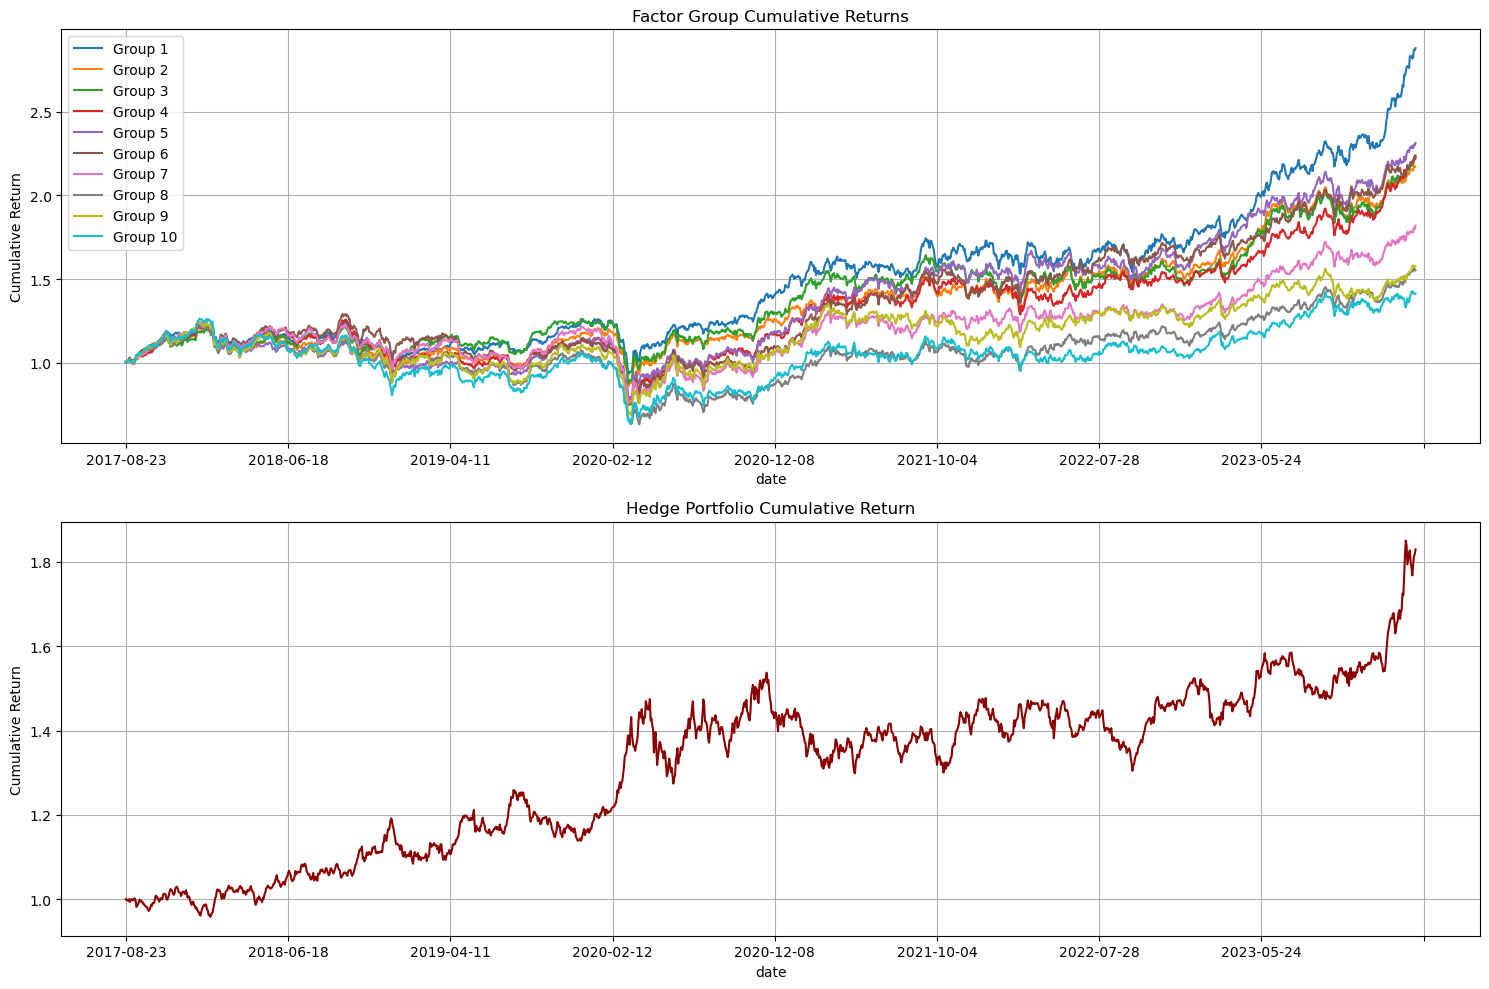

回测结果:
      IC   ICIR  Annual Return  Volatility  Sharpe Ratio  Max Drawdown  \
0 -0.006 -0.067          0.182       0.168         1.081          0.26   

   Hedge Annual Return  Hedge Volatility  Hedge Sharpe Ratio  \
0                0.104             0.131               0.794   

   Hedge Max Drawdown  
0               0.155  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")


class FactorBacktester:
    def __init__(self, data):
        """

        :param data: 
            ['ticker', 'date', 'last', 'mkt_cap', 'bics_sector', 'volume', 'factor']
        """
        self.data = data.sort_values(["ticker", "date"]).copy()
        self.pnl = pd.DataFrame()
        self.ic = []
        self.result = pd.DataFrame()
        self._preprocess_data()

    def _preprocess_data(self):

        self.data["next_return"] = self.data.groupby("ticker")["last"].pct_change().shift(-1)


        self.data = self.data.dropna(subset=["factor", "next_return"])

    def run_backtest(self):

        unique_dates = self.data["date"].unique()


        for i, date in enumerate(unique_dates[:-1]):
            current_date_data = self.data[self.data["date"] == date]
            next_date = unique_dates[i + 1]


            next_date_data = self.data[self.data["date"] == next_date][["ticker", "next_return"]]
            merged = pd.merge(current_date_data, next_date_data, on="ticker", suffixes=("", "_next"))

            if not merged.empty:
                self._process_daily_data(merged, date)

    def _process_daily_data(self, daily_data, date):
        """处理单日数据"""
        # Factor grouping (10 groups)
        daily_data["group"] = pd.qcut(daily_data["factor"], 10, labels=False, duplicates="drop") + 1

        # Calculate group returns
        group_returns = daily_data.groupby("group")["next_return_next"].mean()


        pnl_record = pd.DataFrame(group_returns).T
        pnl_record["date"] = date
        pnl_record.set_index("date", inplace=True)
        self.pnl = pd.concat([self.pnl, pnl_record])

        # 

        ic_value = daily_data["factor"].corr(daily_data["next_return_next"])
        self.ic.append(ic_value)

    def analyze_results(self):
        """分析结果并生成报告"""
        ic_mean = np.mean(self.ic)
        ic_std = np.std(self.ic)
        icir = ic_mean / ic_std if ic_std != 0 else 0

        # Process grouped returns
        self.pnl["hedge"] = self.pnl[1] - self.pnl[10]

        # Calculate cumulative earnings
        cumulative_returns = (1 + self.pnl).cumprod()

        # 
        self._plot_results(cumulative_returns)


        metrics = self._calculate_metrics(cumulative_returns)


        self.result = pd.DataFrame([{"IC": round(ic_mean, 3), "ICIR": round(icir, 3), **metrics["long"], **metrics["hedge"]}])

        return self.result

    def _calculate_metrics(self, cumulative_returns):
        """计算风险指标"""
        # Bullish indicators (Group 1)
        long_returns = self.pnl[1]
        long_metrics = {
            "Annual Return": round(long_returns.mean() * 252, 3),
            "Volatility": round(long_returns.std() * np.sqrt(252), 3),
            "Sharpe Ratio": round(long_returns.mean() / long_returns.std() * np.sqrt(252), 3),
            "Max Drawdown": round(self._max_drawdown(cumulative_returns[1]), 3),
        }

        # Hedge portfolio indicators
        hedge_returns = self.pnl["hedge"]
        hedge_metrics = {
            "Hedge Annual Return": round(hedge_returns.mean() * 252, 3),
            "Hedge Volatility": round(hedge_returns.std() * np.sqrt(252), 3),
            "Hedge Sharpe Ratio": round(hedge_returns.mean() / hedge_returns.std() * np.sqrt(252), 3),
            "Hedge Max Drawdown": round(self._max_drawdown(cumulative_returns["hedge"]), 3),
        }

        return {"long": long_metrics, "hedge": hedge_metrics}

    def _max_drawdown(self, cumulative_series):
        """计算最大回撤"""
        max_vals = cumulative_series.cummax()
        drawdowns = (max_vals - cumulative_series) / max_vals
        return drawdowns.max()

    def _plot_results(self, cumulative_returns):
        """绘制结果图表"""
        plt.figure(figsize=(15, 10))

        # Group income chart
        ax1 = plt.subplot(211)
        for group in range(1, 11):
            cumulative_returns[group].plot(ax=ax1, label=f"Group {group}")
        ax1.set_title("Factor Group Cumulative Returns")
        ax1.set_ylabel("Cumulative Return")
        ax1.legend()
        ax1.grid(True)

        #Hedge portfolio return chart
        ax2 = plt.subplot(212)
        cumulative_returns["hedge"].plot(ax=ax2, color="darkred")
        ax2.set_title("Hedge Portfolio Cumulative Return")
        ax2.set_ylabel("Cumulative Return")
        ax2.grid(True)

        plt.tight_layout()
        plt.show()



df_merged = pd.read_csv("amihud.csv")  # 可替换为amihud.csv/turnover.csv/industry_crowdedness.csv


backtester = FactorBacktester(df_merged)

backtester.run_backtest()


results = backtester.analyze_results()


print("回测结果:")
print(results[["IC", "ICIR", "Annual Return", "Volatility", "Sharpe Ratio", "Max Drawdown", "Hedge Annual Return", "Hedge Volatility", "Hedge Sharpe Ratio", "Hedge Max Drawdown"]])

